In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
import pyecharts as pye
from scipy.stats import norm

In [7]:
from IPython.display import clear_output

In [4]:
stock_list = os.listdir(r"C:\Users\user\Desktop\股票資料")

## 對數收益率

In [5]:
# 收益 LOG
df_re0 = pd.DataFrame()
for file in stock_list:
    df_t = pd.read_csv(r"C:\Users\user\Desktop\股票資料\%s"%file , encoding="big5")
    value = df_t["收盤價"]
    srate = np.log(value/value.shift(1))[1:]
    df_re0[file[0:-4]] = srate
print(df_re0.describe())
df_re0.corr()
#df_re0.to_csv(r"C:\Users\user\Desktop\初步統計\df_re0.csv",encoding="big5")

             0050      00632R        1101        1216        2330        2884
count  488.000000  488.000000  488.000000  488.000000  488.000000  488.000000
mean     0.000328   -0.000560    0.000366    0.000203    0.000724    0.000798
std      0.009491    0.008695    0.016867    0.013633    0.015555    0.009326
min     -0.072861   -0.033953   -0.165401   -0.070132   -0.070018   -0.066201
25%     -0.004318   -0.005298   -0.005251   -0.007113   -0.008791   -0.004477
50%      0.000605   -0.000856    0.001190    0.001258    0.001641    0.000000
75%      0.005951    0.003570    0.007879    0.008395    0.010510    0.005398
max      0.033665    0.073880    0.064685    0.054951    0.056292    0.032221


,0050,00632R,1101,1216,2330,2884
0050,1.000000,-0.948457,0.401639,0.413434,0.837853,0.450546
00632R,-0.948457,1.000000,-0.427772,-0.452066,-0.792997,-0.474670
1101,0.401639,-0.427772,1.000000,0.268391,0.273661,0.363841
1216,0.413434,-0.452066,0.268391,1.000000,0.283353,0.249445
2330,0.837853,-0.792997,0.273661,0.283353,1.000000,0.317148
2884,0.450546,-0.474670,0.363841,0.249445,0.317148,1.000000


In [8]:
### Start to derive weight
weight = []
returns = []
risk = []
sharpe = []

num_stock = len(stock_list)
num_portfo = 100000
for i in range(num_portfo):
    if i%1000 ==0:
        print(round((i/num_portfo)*100,2),"%")
        clear_output(wait = True)
    portfo_weight = np.random.random(num_stock)
    portfo_weight /= np.sum(portfo_weight)
    weight.append(portfo_weight)
    portfo_return = pow(np.dot(portfo_weight,df_re0.mean())+1,244)-1
    portfo_risk = np.sqrt(np.dot( portfo_weight.T, np.dot(df_re0.cov()*244, portfo_weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    returns.append(portfo_return)
    risk.append(portfo_risk)
    sharpe.append(portfo_sharpe)

99.0 %


In [9]:
portfolio = {"return":returns,"risk":risk,"sharpe":sharpe}  ###把資料都丟到字典裡
for index,stock in enumerate(stock_list):
    portfolio[stock[0:-4]+"weight"] = [each[index] for each in weight]
### 生出PORTFOLIO DATAFRAME
df_portfolio = pd.DataFrame(portfolio)
df_portfolio.describe()

,return,risk,sharpe,0050weight,00632Rweight,1101weight,1216weight,2330weight,2884weight
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05
mean,0.078978,0.107254,0.623634,0.166474,0.166636,1.665978e-01,0.166740,1.664047e-01,1.671478e-01
std,0.029845,0.024198,0.215654,0.095221,0.095386,9.540455e-02,0.095132,9.505907e-02,9.509769e-02
min,-0.064280,0.023287,-1.481005,0.000002,0.000005,1.936543e-07,0.000002,7.676046e-08,6.233194e-07
25%,0.058743,0.090080,0.509854,0.090211,0.090457,9.013870e-02,0.090600,9.109922e-02,9.176563e-02
50%,0.078621,0.106235,0.647925,0.166252,0.166612,1.666842e-01,0.167096,1.661839e-01,1.671828e-01
75%,0.100201,0.125380,0.766907,0.233354,0.233322,2.335587e-01,0.233546,2.327535e-01,2.337215e-01
max,0.190772,0.206746,1.373464,0.710243,0.718521,7.275049e-01,0.676947,7.512497e-01,7.127462e-01


In [11]:
df_best = df_portfolio[df_portfolio["sharpe"].isin([df_portfolio["sharpe"].max()])]

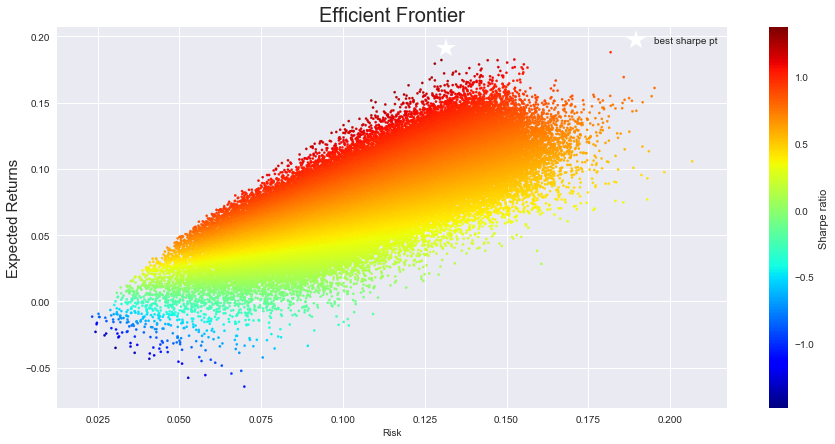

In [16]:
## 散點圖!!
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.style.use("seaborn")

plt.scatter(x =df_portfolio["risk"],y =df_portfolio["return"],s = 5,c=df_portfolio["sharpe"],cmap = "jet")
plt.plot(df_best["risk"],df_best["return"],"w*",markersize = 20,label ="best sharpe pt")

plt.xlabel("Risk",fontsize=10)
plt.ylabel('Expected Returns',fontsize=15)
plt.title('Efficient Frontier',fontsize=20)
plt.colorbar(label='Sharpe ratio')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### 求解SHARPE最優

## 構造有效前緣
### 求解夏普最優(i mean for all the feasible portfolios)

In [19]:
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

In [20]:
#最大夏普率
def indexes(weight,df = df_re0):
    portfo_return = pow(np.dot(weight,df.mean())+1,244)-1
    portfo_risk = np.sqrt(np.dot(weight.T, np.dot(df.cov()*252,weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    return np.array([portfo_return, portfo_risk, portfo_sharpe])
def min_sharpe(weight):         ###Object function
    return -indexes(weight,df_re0)[2]  ###因為scipy.optimize只有minimize。。。
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(stock_list)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(stock_list):
     print(j[0:-4]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs = sco.minimize(min_sharpe , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(stock_list):
     print(j[0:-4]," = ",solvs['x'].round(3)[i])  #即为最大夏普率的投资组合的权重分配print
print(indexes(solvs['x']).round(3))  #获得最大夏普率的投资组合的收益率、波动率和夏普率
#最小方差的投资组合

------------------Initial Condition----------------------
0050  =  0.167
00632R  =  0.167
1101  =  0.167
1216  =  0.167
2330  =  0.167
2884  =  0.167
---------------------------------------------------------


     fun: -1.4200775194722413
     jac: array([ 0.22582236,  0.31686345,  0.28745227,  0.20783645, -0.21765789,
       -0.21749078])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([3.92213621e-17, 0.00000000e+00, 0.00000000e+00, 1.43385210e-16,
       1.36102826e-01, 8.63897174e-01])


------------------Optimal Condition----------------------
0050  =  0.0
00632R  =  0.0
1101  =  0.0
1216  =  0.0
2330  =  0.136
2884  =  0.864
[0.212 0.142 1.42 ]


### 最小VARIANCE

In [21]:
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(stock_list)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(stock_list):
     print(j[0:-4]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs2 = sco.minimize(min_variance , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs2)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(stock_list):
     print(j[0:-4]," = ",solvs2['x'].round(3)[i])  #即为最大夏普率的投资组合的权重分配print
print(indexes(solvs2['x']).round(3))  #获得最大夏普率的投资组合的收益率、波动率和夏普率
#最小方差的投资组合

------------------Initial Condition----------------------
0050  =  0.167
00632R  =  0.167
1101  =  0.167
1216  =  0.167
2330  =  0.167
2884  =  0.167
---------------------------------------------------------


     fun: 0.0004669123164809591
     jac: array([0.00098833, 0.00088654, 0.00094263, 0.00088841, 0.00101762,
       0.00098298])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([4.23568085e-01, 5.05826599e-01, 9.75638215e-03, 2.38130985e-02,
       1.93865626e-04, 3.68419701e-02])


------------------Optimal Condition----------------------
0050  =  0.424
00632R  =  0.506
1101  =  0.01
1216  =  0.024
2330  =  0.0
2884  =  0.037
[-0.026  0.022 -1.648]


100.0 %
[0.1380242272438985, 0.13802422724389687, 0.13802422724375105, 0.13802422724384983, 0.13802422724385355, 0.13802422724388408, 0.13802422724387214, 0.13802422724383956, 0.13802422724388508, 0.13802422724387053, 0.13802422724383667, 0.13802422724389382, 0.13802422724381333, 0.1380242272438887, 0.1380242272438119, 0.13802422724363494, 0.1380242272438045, 0.13802422724379879, 0.1380242272438277, 0.13802422724384109, 0.13802422608554007, 0.13802422724389726, 0.13802422724386484, 0.13802422724387067, 0.13802422724387023, 0.13802422722956792, 0.1380242272417008, 0.1380242272426516, 0.13498395785738812, 0.11022662936922031, 0.08619197285382568, 0.06311170444385555, 0.04173287084260189, 0.02530180806601926, 0.021636237712464902, 0.024603166390307196, 0.030989195225826476, 0.039017405317009944, 0.04776308765626004, 0.05681722948638695, 0.06598579103236367, 0.07517669535426866, 0.08455787905383219, 0.09412017425976253, 0.10381136444105926, 0.11357417187472922, 0.12335348161825653, 0.13311

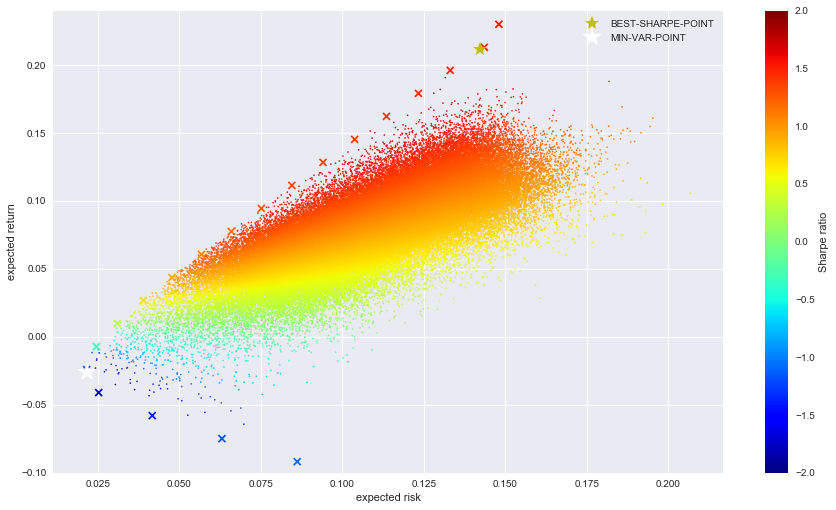

In [22]:
### plot the frontier
def best_port(weight):
    return indexes(weight)[1]
return_interval = np.linspace(-0.6,0.23,50)
corr_risk = []
i = 0
for prt in return_interval:
    i+=1
    clear_output(wait = True)
    print(i/len(return_interval)*100,"%")
    cons = ({'type': 'eq', 'fun': lambda x:  indexes(x)[0] - prt},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(best_port, initial_cond, method='SLSQP',
                       bounds=bnds, constraints=cons)
    corr_risk.append(indexes(res["x"])[1])
print(corr_risk)
corr_risk = np.array(corr_risk)
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(15, 8.5)
plt.scatter(df_portfolio["risk"],df_portfolio["return"],s = 1.5,c = df_portfolio["sharpe"],marker = "o",cmap = plt.cm.jet)

plt.scatter(corr_risk, return_interval,c = (return_interval) / corr_risk, marker='x',cmap = plt.cm.jet)
plt.plot(indexes(solvs['x'])[1], indexes(solvs['x'])[0],'y*', markersize=15.0,label = "BEST-SHARPE-POINT")
plt.plot(indexes(solvs2["x"])[1],indexes(solvs2["x"])[0],'w*',markersize=20.0,label = "MIN-VAR-POINT")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

plt.ylim(-0.1,0.24)
plt.grid(True)
plt.xlabel('expected risk')
plt.ylabel('expected return')
plt.clim(-2,2)
plt.colorbar(label='Sharpe ratio')
plt.legend()